### **Box Office Revenue Prediction**

Import libraries and read in data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from IPython.testing.skipdoctest import skip_doctest
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

trainData = pd.read_csv('/train.csv',sep=',')
train_data = trainData.copy()
testData = pd.read_csv('/test.csv',sep=',')
test_data = testData.copy()

Traverse coulmuns with dictionary using Anstract Syntax Tree to store individual values

In [2]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train_data = text_to_dict(train_data)
test_data = text_to_dict(test_data)


Change variable with dictionaries to multiple variables with suitable values

In [3]:
train_data['collection_name'] = train_data['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train_data['has_collection'] = train_data['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test_data['collection_name'] = test_data['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test_data['has_collection'] = test_data['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train_data = train_data.drop(['belongs_to_collection'], axis=1)
test_data = test_data.drop(['belongs_to_collection'], axis=1)

def mainGenre(df):
    df['main_genre'] = df['genres'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df.loc[df['main_genre'] == 0, 'main_genre'] = 'zero'

mainGenre(train_data)
mainGenre(test_data)

Convert the categorical "main_genere" variable created above to multiple one-hot encoded vectors, to see if movies with a specific main genre usually generate more revenue

In [4]:
one_hot = pd.get_dummies(train_data['main_genre'])
train_data = train_data.join(one_hot)

one_hot1 = pd.get_dummies(test_data['main_genre'])
test_data = test_data.join(one_hot1)

See the distribution of spoken languages for a movie

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


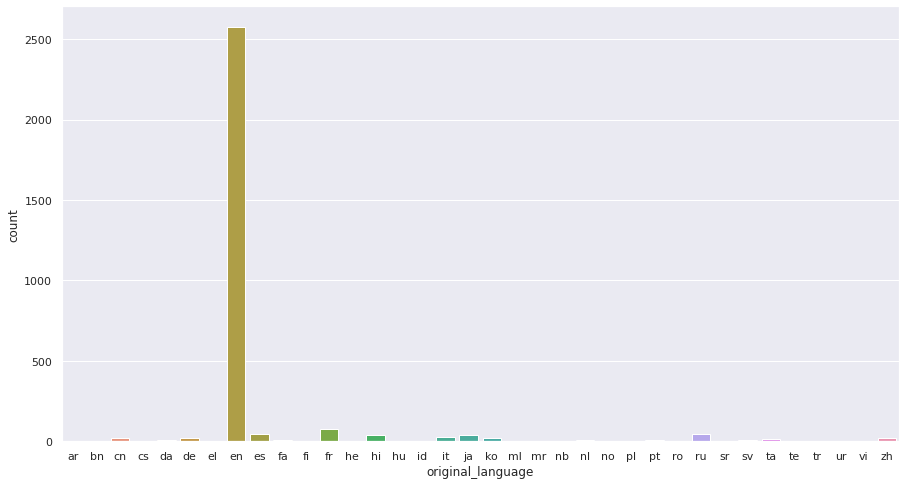

In [5]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(train_data['original_language'].sort_values())

Since most movies are in English, encode if the original language is English or not and whether there exists a homepage before the release

In [6]:
def ogLanguage(df):
    df['original_language'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)

ogLanguage(train_data)
ogLanguage(test_data)

def homepageBinary(df):
    df['homepage'] = df['homepage'].notnull().astype(int)
homepageBinary(train_data)
homepageBinary(test_data)

Calculate investment in movie for the given time, by encoding budget to year ratio

In [7]:
def budget_year(df):    
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['year'], df['month'] = df['release_date'].dt.year, df['release_date'].dt.month
    
    df['budget'] = df['budget'].fillna(df['budget'].mean())
    
    df['budget_year_ratio'] = df['budget'] / df['year']

budget_year(train_data)
budget_year(test_data)

Encode if the cast in the movie includes any popular actors

In [8]:
def cast(df):
    cast_names = list(df['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    cast_names = Counter([i for j in cast_names for i in j]).most_common()
    
    top_actors = [m[0] for m in cast_names][:40]
    
    df['popular_actors'] = df['cast'].apply(lambda x: 1 if any(m['name'] in top_actors for m in x) else 0)
cast(train_data)
cast(test_data)

Find out the main revenue generating companies and encode if one of the 'high_value' companies was involved with the movie or not as a binary

In [9]:
def mpc(df):
    main_company = []
    for i in range(len(df)):

        if(df['production_companies'].iloc[i] == {}):
            main_company.append(None)
        else:
            main_company.append(df['production_companies'].iloc[i][0].get('name'))

    df['main_production_company'] = main_company
    companies = train_data.groupby('main_production_company')['revenue'].mean().sort_values(ascending=False)
    companies = companies[0:18]
    companies = list(companies.index.values) 
    #df.fillna("other", inplace=True)
    
    df['high_value'] = 0
    
    df['high_value'] = df['main_production_company'].apply(lambda x: 1 if str(x) in companies else 0)
    
    
mpc(train_data)
mpc(test_data)

See the correlation of various variables with revnue

In [10]:
corr_matrix = train_data.corr()
corr_matrix['revenue'].sort_values(ascending= False)

revenue              1.000000
budget               0.752965
budget_year_ratio    0.752618
high_value           0.464191
popularity           0.461460
has_collection       0.339425
homepage             0.263179
Adventure            0.226857
runtime              0.216380
popular_actors       0.162181
original_language    0.142130
Animation            0.095393
Action               0.089479
Science Fiction      0.083127
Family               0.072629
month                0.020164
Fantasy              0.017298
year                 0.005087
id                   0.000610
Western             -0.000873
TV Movie            -0.003283
History             -0.011975
Foreign             -0.012507
Mystery             -0.014611
Thriller            -0.014806
Romance             -0.016572
Music               -0.019562
zero                -0.023076
War                 -0.025223
Horror              -0.030548
Crime               -0.042763
Comedy              -0.069268
Documentary         -0.071543
Drama     

Observe distribution of highly correlated features

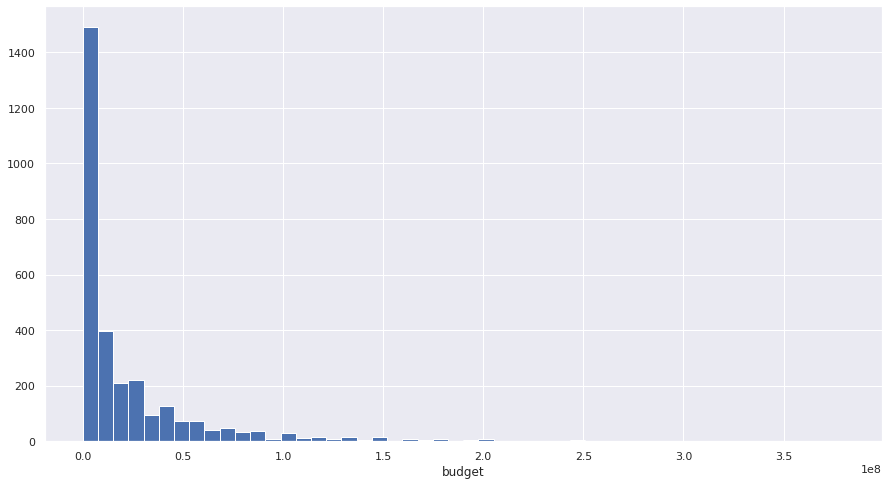

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
plt.xlabel( 'budget')
hist = plt.hist(train_data['budget'],bins = 50)

Remove entries with extremely low budgets and log transform for better distribution

<ipython-input-12-ea2139b45048>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['budget']= train_data['budget'].apply(lambda x : x+MEAN if x<100000  else x)
<ipython-input-12-ea2139b45048>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_budget'] = np.log1p(train_data['budget'])


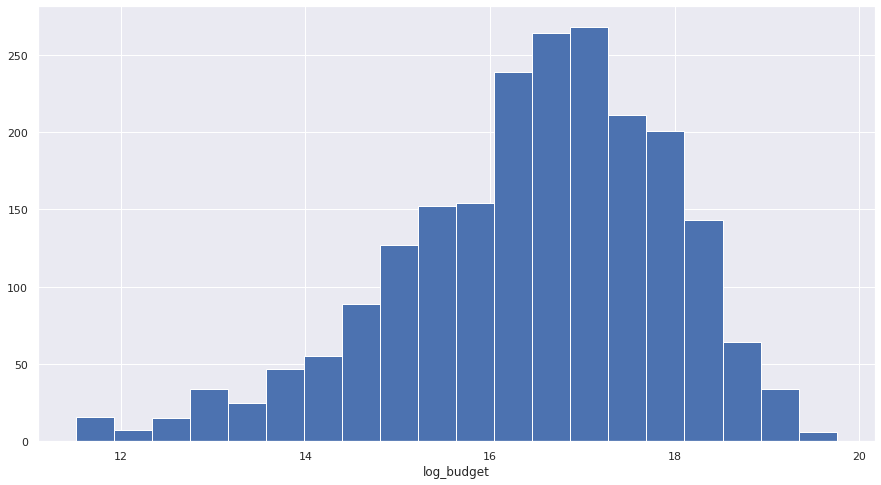

In [12]:
train_data = train_data[train_data['budget'] >= 100000]
MEAN = train_data['budget'].mean()
train_data['budget']= train_data['budget'].apply(lambda x : x+MEAN if x<100000  else x)
train_data['log_budget'] = np.log1p(train_data['budget'])
test_data['log_budget'] = np.log1p(test_data['budget'])
plt.xlabel( 'log_budget')
hist = plt.hist(train_data['log_budget'],bins = 20)

Similarly for budget_year_ratio:

In [13]:
MEAN = train_data['budget_year_ratio'].mean()
train_data['budget_year_ratio']= train_data['budget_year_ratio'].apply(lambda x : x+MEAN if x<100000  else x)
train_data['log_budget_year_ratio'] = np.log1p(train_data['budget_year_ratio'])
test_data['log_budget_year_ratio'] = np.log1p(test_data['budget_year_ratio'])

Choose the features, use mean imputation for missing values and feed to the **Random forest regressor model** and print the MAE and R2 score on training set

In [14]:
y = train_data.revenue
features = ['log_budget','log_budget_year_ratio','popularity',"runtime","high_value","has_collection","homepage","Adventure"]
train_x = train_data[features]
test_id = test_data["id"]
test_x = test_data[features]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(train_x)
train_x = imputer.transform(train_x)
imputer = imputer.fit(test_x)
test_x = imputer.transform(test_x)
Rf_model = RandomForestRegressor(random_state=1)
Rf_model.fit(train_x,y)
Rf_predictions_train = Rf_model.predict(train_x)
print(mean_absolute_error(Rf_predictions_train,y))
print(r2_score(Rf_predictions_train,y))


18514852.638516966
0.943674965129391


Predict on test set and save the submission file

In [15]:
Rf_predictions_test = Rf_model.predict(test_x)
file_to_submit = pd.DataFrame({'id': test_id, 'revenue':Rf_predictions_test})
file_to_submit = file_to_submit[['id', 'revenue']]
file_to_submit.to_csv("file_to_submit.csv", index=False)